Implement the Metropolis-Hastings algorithm for the given target and proposal distributions.
1. Run the algorithm with each of the values ε = 0.5, 1, 2, 4.
2. For each ε, plot the samples, x_t, for t = 0, 1, . . . , 1000 to show how the samples change over time. Your plot should look something like this

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
from scipy import signal

In [62]:
def target_pdf(x):
    return sts.norm(-4, 0.5).pdf(x) + sts.norm(4, 1**2).pdf(x)

def metropolis_hastings(target, length_scale, size=1000):
    '''
    q(x_t, x_(t-1)) = N(x_t | x_(t-1), length_scale)
    '''
    
    #Can change this later to adapt the bounds of the uniform
    #to the 1st and 99th percentiles  of the target dist
    x = sts.uniform(-10, 10).rvs()
    
    #Initialize storage vector, append first x
    samples = [x]
    accept_count = 0
    for i in range(size):
        
        #Draw proposal from proposal distribution
        x_proposed = sts.norm(x, length_scale).rvs()
        
        #Probability ratio
        a = target(x_proposed)/target_pdf(x)
        
        #Accept proposal with probability min(1, a)
        if min(1, a) > np.random.rand():
            x = x_proposed
            accept_count +=1
        
        #Regardless of acceptance, append x
        samples.append(x)

    
    return samples, accept_count/size

In [63]:
#Run metropolis-hastings algo for each of the different length scales
length_scales_samples = {x:metropolis_hastings(target_pdf, x) for x in [0.5, 1, 2, 4]}

In [90]:
def plot_samples(length_scale):       
    plt.figure(figsize=(12, 7))
    plt.title('Metropolis-Hastings algorithm with length scale %0.1f, \n sample acceptance rate %0.2f'
              % (length_scale, length_scales_samples[length_scale][1]))
    plt.ylim(-0.1, 1)
    
    #Plot the target distribution
    x = np.linspace(-7, 8, 500)
    plt.plot(x, target_pdf(x), label="target distribution", color="black")
    
    #Plot samples
    plt.plot(length_scales_samples[length_scale][0], sts.uniform.rvs(loc=-0.04, scale=0.03, size=1001), 
            'gx', markersize = 0.8, alpha=0.3, label="samples", color="black")
    #Plot sample sequence
    plt.plot(length_scales_samples[length_scale][0], np.linspace(0, 1, 1001), alpha=0.5, 
             label="sample sequence", color="black")
    
    plt.legend(loc=0)
    plt.show()
    
def plot_autocorrelation(length_scale):
    plt.figure(figsize=(10, 6))
    samples = length_scales_samples[length_scale][0]
    plt.acorr(samples, maxlags=20, 
              detrend=lambda samples: signal.detrend(samples, type='constant'))
    plt.title('Autocorrelation of samples')
    plt.show()

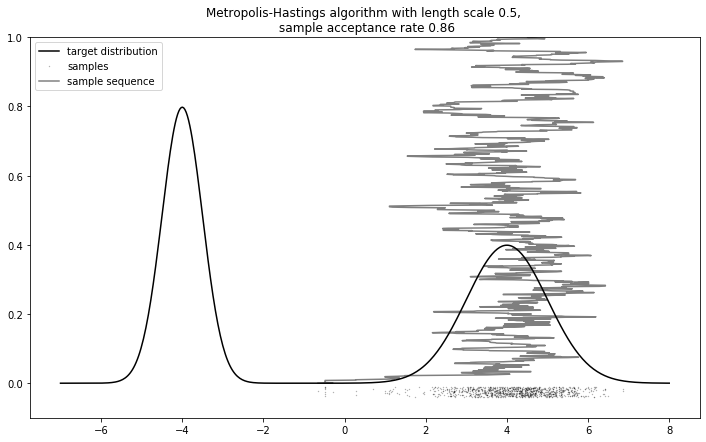

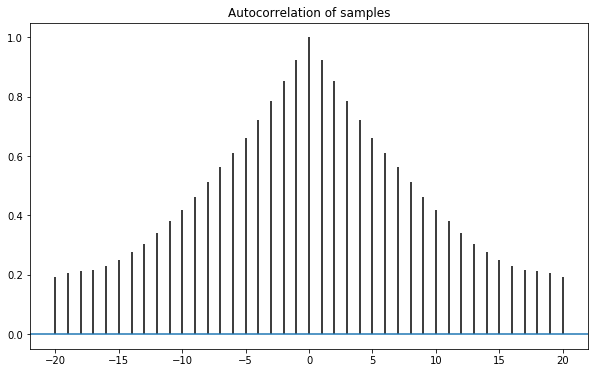

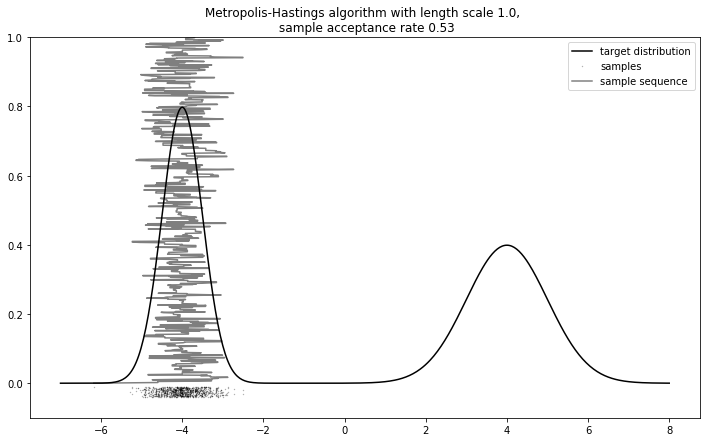

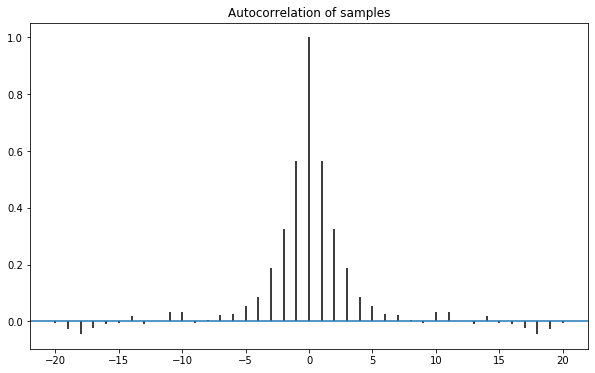

In [91]:
#Plot the results for each length scale
for length_scale in list(length_scales_samples.keys())[:2]:
    plot_samples(length_scale)
    plot_autocorrelation(length_scale)

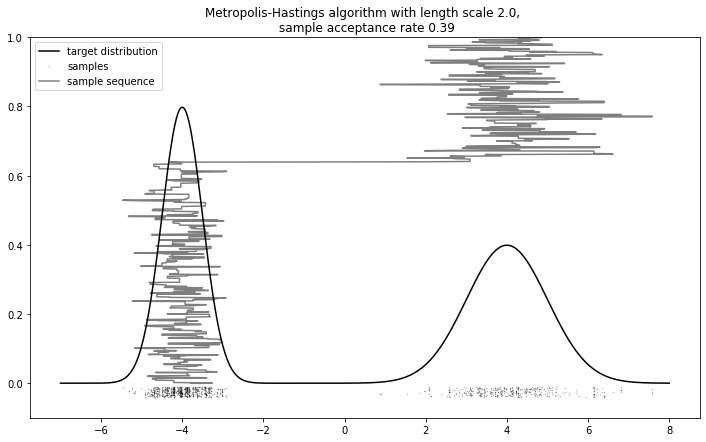

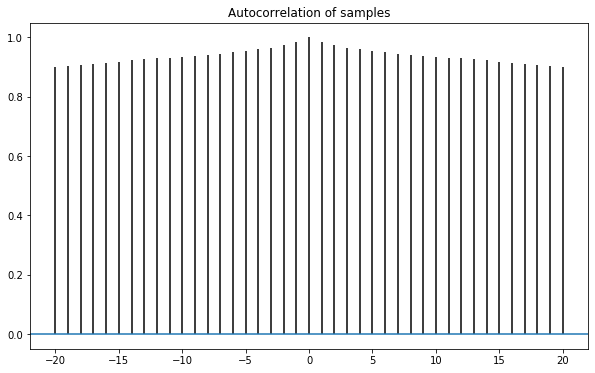

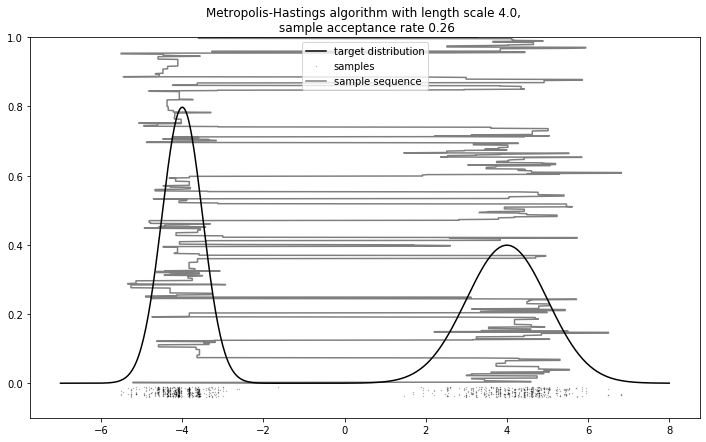

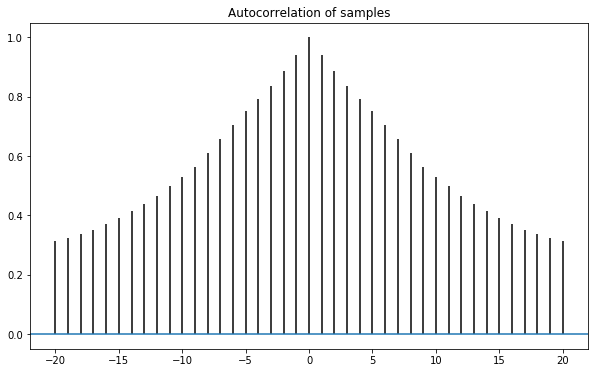

In [92]:
for length_scale in list(length_scales_samples.keys())[2:]:
    plot_samples(length_scale)
    plot_autocorrelation(length_scale)

Looking at where the samples were drawn, i.e. the samples plot, I would say that length scale 2 got the best approximation of the target distribution. However, it is also the length-scale that results in the strongest, most persistent autocorrelation between samples, which is negative as our objective is to draw independent samples from the target distribution.

This leaves me somewhat torn. For example, length-scale 1 has by far the lowest degree of autocorrelation–after ~+-7 samples it is 0. However, it is also absolutely clear that the approximation of the target distribution is awful, because it only ever explored one of the two gaussians that compose the target distribution.

In the end, I still think length-scale 2 is the best. But the only reason I can tell that in this case is because I am able to visually compare the samples to the target distribution. If the target distribution is of higher degree this approach clearly is not viable. Better to compute KL-divergence between a kernel density estimate of the samples from the target distribution and the target distribution?

Or what are better ways to tell if your proposal distribution sucks?